## Seccion 1 
Limpieza y reduccion del dataset


In [ ]:
"""
Librerias que se permiten usar
"""
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [18]:
def seccion_1_limpieza_y_agregacion(ruta_entrada, ruta_salida):
    """
    Ejecuta la limpieza completa del dataset original y genera una versión
    simplificada del conjunto de datos, lista para análisis estadístico.

    Parámetros:
        ruta_entrada (str): Ruta del archivo CSV original.
        ruta_salida (str): Ruta del archivo CSV procesado.

    Retorna:
        pandas.DataFrame: Dataset limpio y agregado.
    """

    """
    Carga del dataset original.
    """
    datos_original = pd.read_csv(ruta_entrada)
    datos_original.columns = datos_original.columns.str.strip()

    filas_originales = datos_original.shape[0]
    columnas_originales = datos_original.shape[1]

    """
    Filtrado por modo de juego CLASSIC.
    """
    datos = datos_original[
        datos_original["game_mode"].astype(str).str.upper() == "CLASSIC"
    ].copy()

    """
    Filtrado por duración mínima de partida (10 minutos).
    """
    datos["game_duration"] = pd.to_numeric(datos["game_duration"], errors="coerce")
    datos = datos[datos["game_duration"] >= 600].copy()

    """
    Conversión de la variable objetivo win a formato binario.
    """
    mapa_win = {
        True: 1, False: 0,
        "TRUE": 1, "FALSE": 0,
        "True": 1, "False": 0,
        "VERDADERO": 1, "FALSO": 0,
        1: 1, 0: 0
    }

    datos["win"] = datos["win"].map(mapa_win)
    datos["win"] = (
        datos["win"]
        .astype(str)
        .str.strip()
        .str.upper()
        .map(mapa_win)
        .fillna(datos["win"])
    )

    datos = datos.dropna(subset=["win"]).copy()
    datos["win"] = datos["win"].astype(int)

    """
    Definición de variables según su tipo de agregación.
    """
    variables_suma = [
        "gold_earned",
        "total_damage_dealt_to_champions",
        "total_damage_taken",
        "damage_dealt_to_turrets",
        "wards_placed",
        "wards_killed"
    ]

    variables_media = [
        "vision_score",
        "champion_mastery_level"
    ]

    variables_equipo = [
        "baron_kills",
        "dragon_kills",
        "win"
    ]

    columnas_requeridas = (
        ["game_id", "team_id"]
        + variables_suma
        + variables_media
        + variables_equipo
    )

    faltantes = [c for c in columnas_requeridas if c not in datos.columns]
    if faltantes:
        raise KeyError(
            "Faltan columnas requeridas en el CSV: " + ", ".join(faltantes)
        )

    """
    Conversión de variables numéricas y eliminación de valores faltantes.
    """
    for c in variables_suma + variables_media + ["baron_kills", "dragon_kills"]:
        datos[c] = pd.to_numeric(datos[c], errors="coerce")

    datos = datos.dropna(
        subset=variables_suma + variables_media + ["baron_kills", "dragon_kills"]
    ).copy()

    """
    Validación de equipos completos (5 jugadores).
    """
    conteo = (
        datos.groupby(["game_id", "team_id"])
        .size()
        .reset_index(name="jugadores_en_equipo")
    )

    datos = datos.merge(conteo, on=["game_id", "team_id"], how="left")
    datos = datos[datos["jugadores_en_equipo"] == 5].copy()
    datos = datos.drop(columns=["jugadores_en_equipo"])

    """
    Construcción del diccionario de agregación.
    """
    agrupacion = {}

    for col in variables_suma:
        agrupacion[col] = "sum"

    for col in variables_media:
        agrupacion[col] = "mean"

    for col in variables_equipo:
        agrupacion[col] = "first"

    """
    Agregación final por game_id y team_id.
    """
    datos_final = (
        datos.groupby(["game_id", "team_id"])
        .agg(agrupacion)
        .reset_index()
    )

    """
    Exportación del dataset procesado.
    """
    datos_final.to_csv(ruta_salida, index=False)

    """
    Cálculo de la reducción general del dataset.
    """
    filas_finales = datos_final.shape[0]
    columnas_finales = datos_final.shape[1]

    print("REDUCCIÓN GENERAL DEL DATASET")
    print(f"Filas originales: {filas_originales}")
    print(f"Filas finales: {filas_finales}")
    print(f"Filas eliminadas: {filas_originales - filas_finales}")
    print(f"Reducción de filas: {(1 - filas_finales / filas_originales):.2%}")

    print("\nColumnas originales:", columnas_originales)
    print("Columnas finales:", columnas_finales)
    print("Columnas eliminadas:", columnas_originales - columnas_finales)
    print(f"Reducción de columnas: {(1 - columnas_finales / columnas_originales):.2%}")

    return datos_final

datos_limpios = seccion_1_limpieza_y_agregacion(
    ruta_entrada="league_data.csv",
    ruta_salida="league_data_etapa1_limpio_equipo.csv"
)

REDUCCIÓN GENERAL DEL DATASET
Filas originales: 40412
Filas finales: 5748
Filas eliminadas: 34664
Reducción de filas: 85.78%

Columnas originales: 94
Columnas finales: 13
Columnas eliminadas: 81
Reducción de columnas: 86.17%


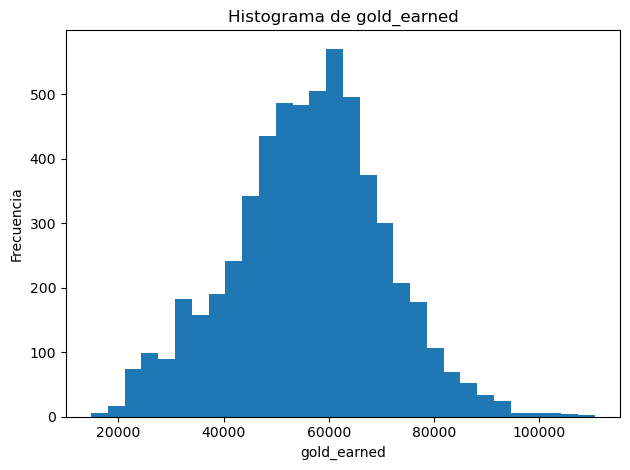

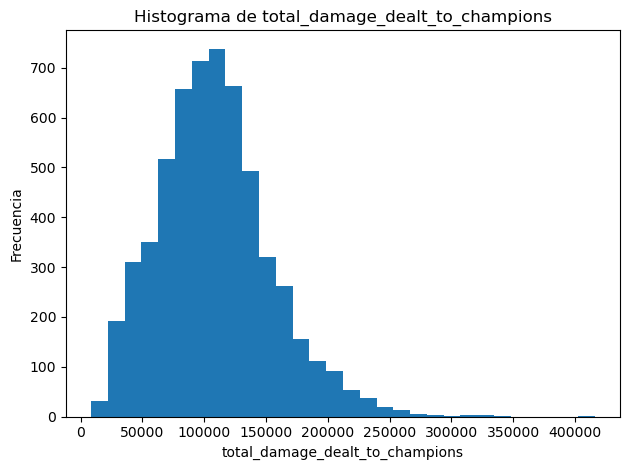

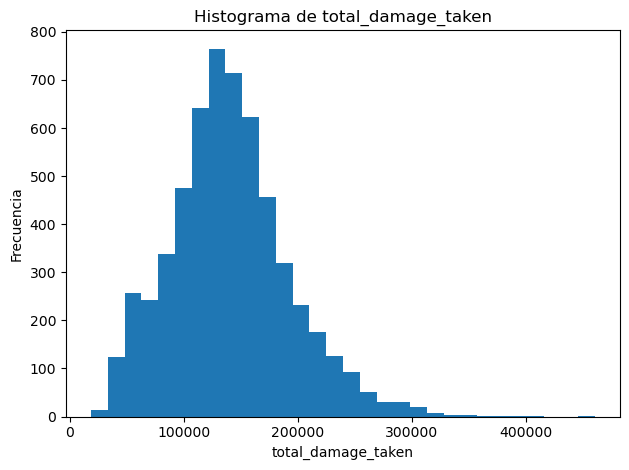

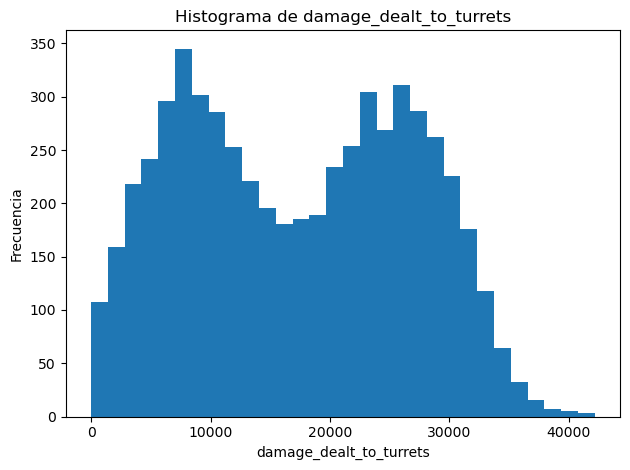

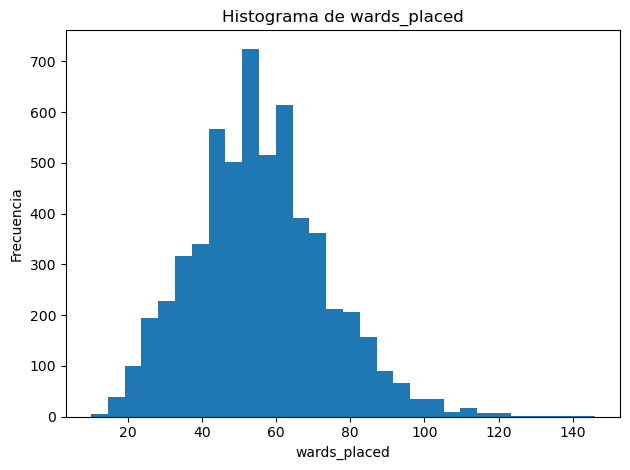

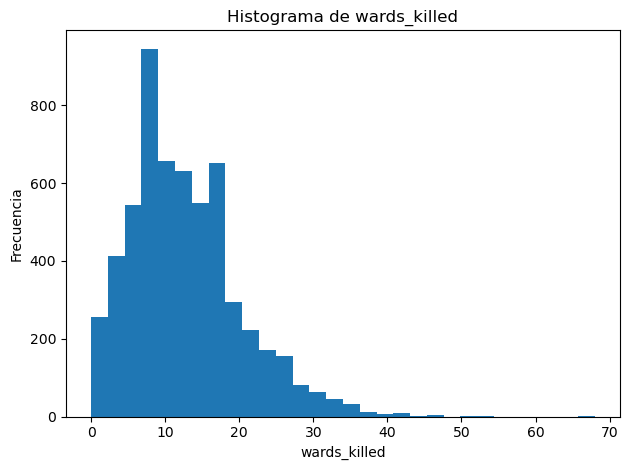

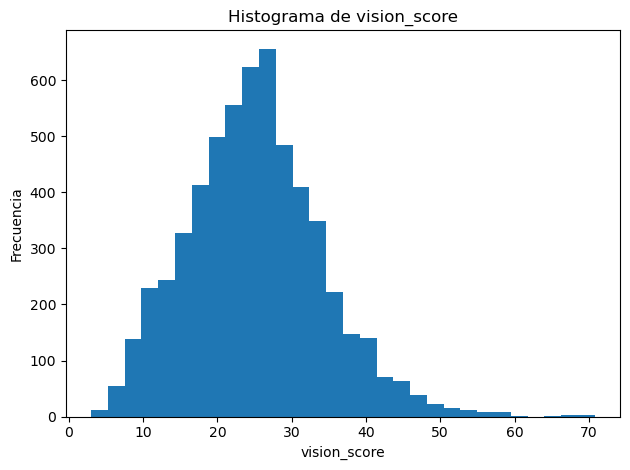

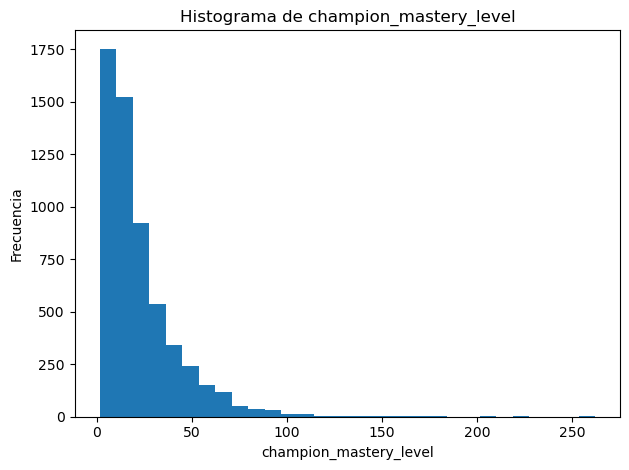

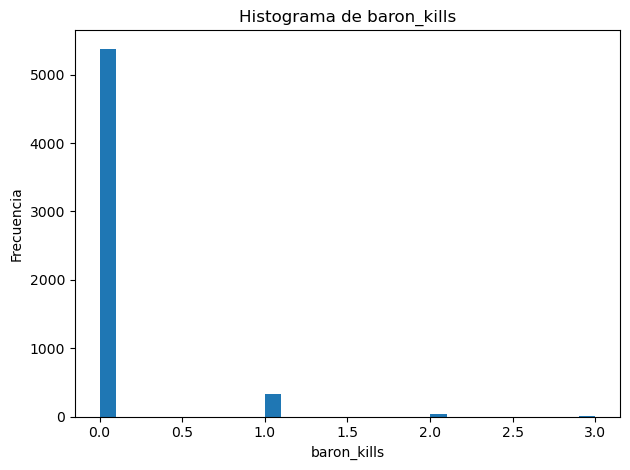

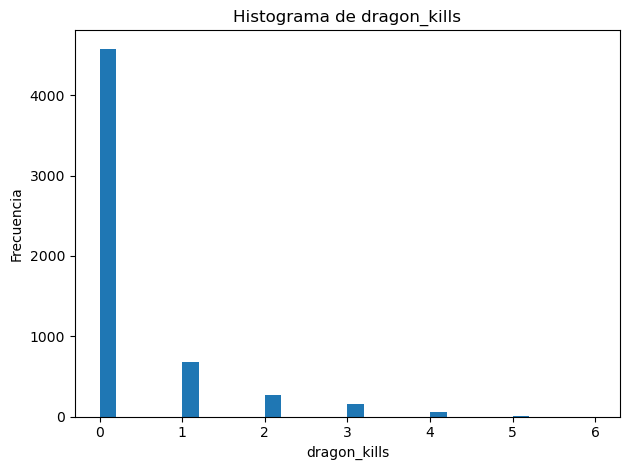

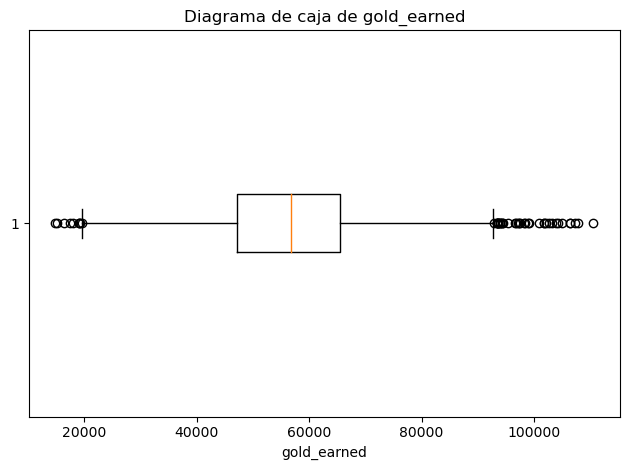

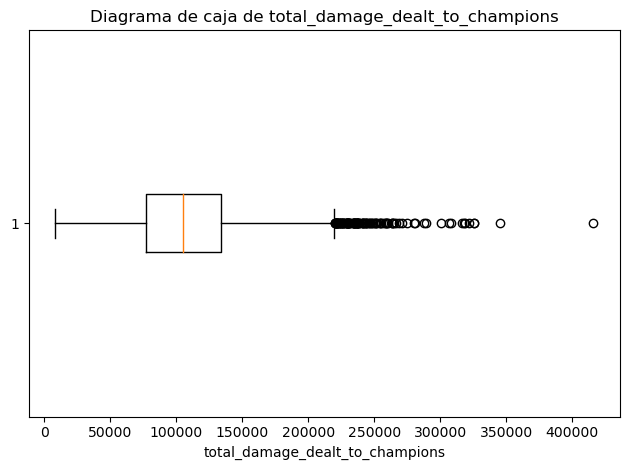

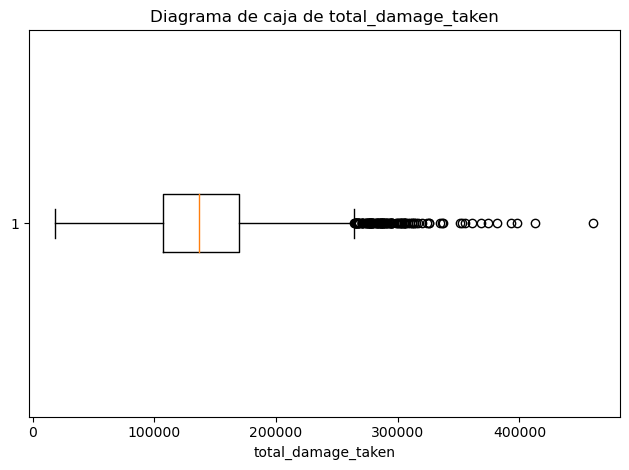

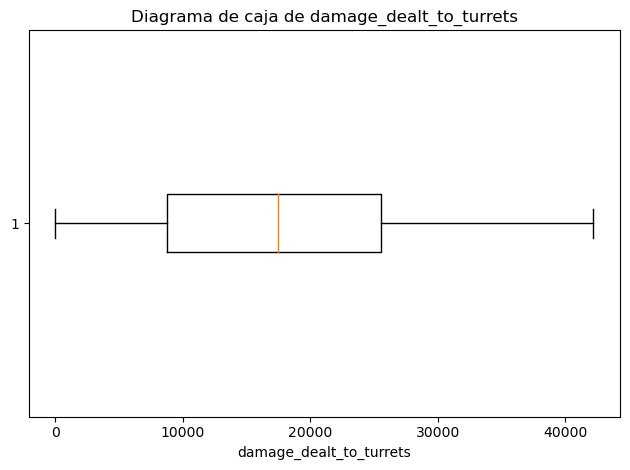

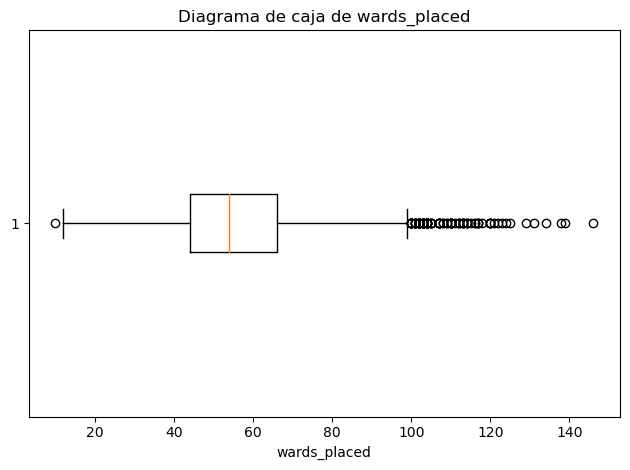

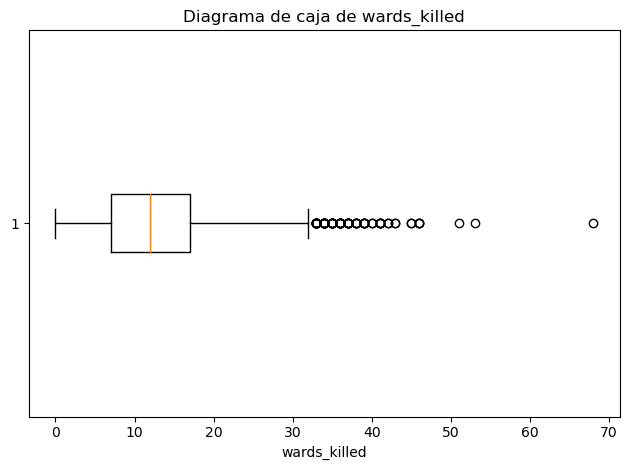

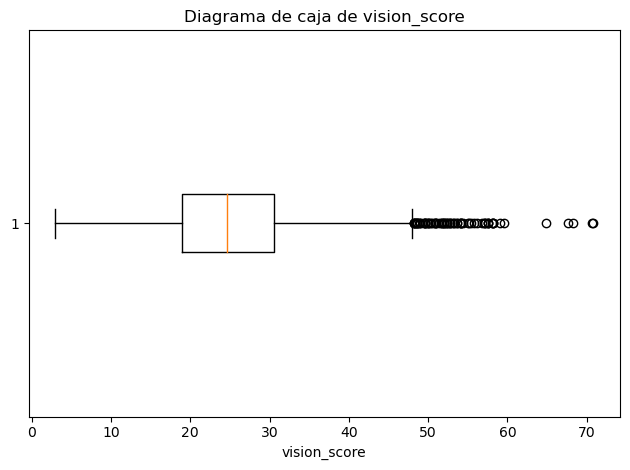

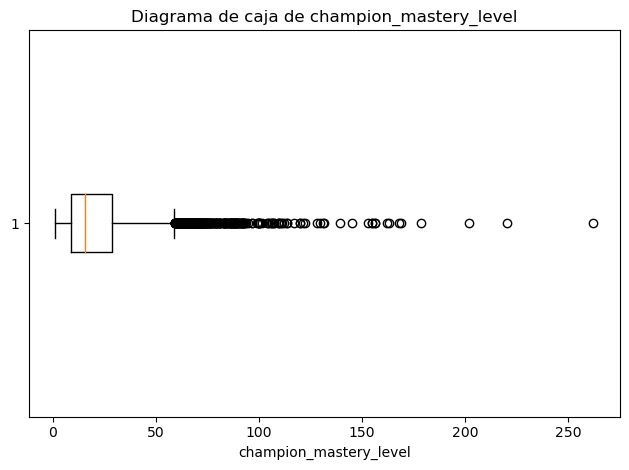

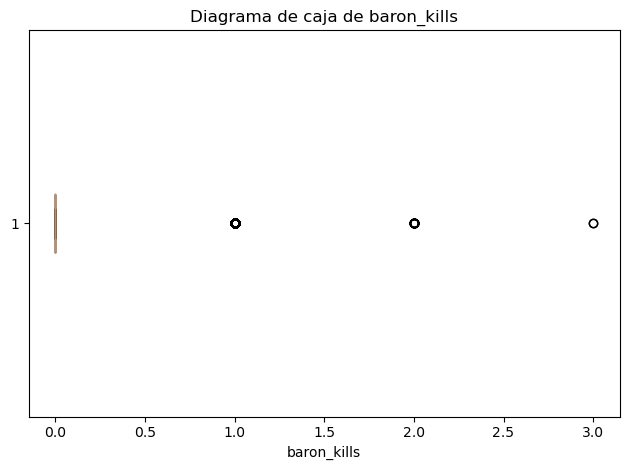

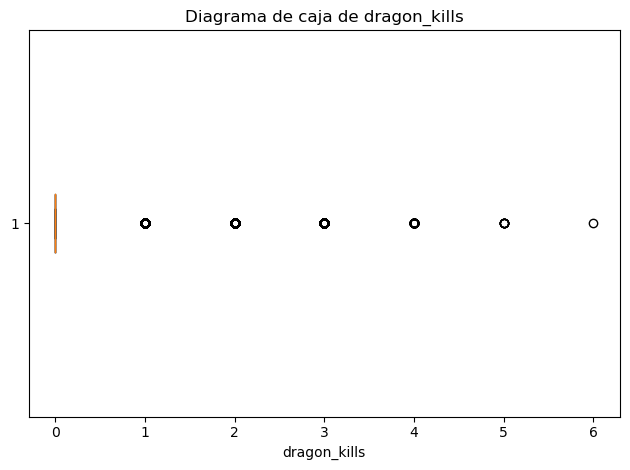

,media,desviacion_estandar,minimo,q1,mediana,q3,maximo
gold_earned,56116.733299,14476.415845,14839.0,47084.5,56715.0,65420.00,110541.0
total_damage_dealt_to_champions,108549.180237,45777.923158,8478.0,77313.5,105170.5,134270.50,415982.0
total_damage_taken,140469.040014,52411.503629,18785.0,106808.0,136898.0,169674.75,460492.0
damage_dealt_to_turrets,17326.174669,9550.107086,0.0,8767.0,17433.5,25563.50,42167.0
wards_placed,55.531489,17.907411,10.0,44.0,54.0,66.00,146.0
wards_killed,12.712248,7.442162,0.0,7.0,12.0,17.00,68.0
vision_score,25.046973,9.031451,3.0,19.0,24.6,30.60,70.8
champion_mastery_level,22.433751,20.096482,1.4,9.0,15.7,29.00,262.2
baron_kills,0.070111,0.280056,0.0,0.0,0.0,0.00,3.0
dragon_kills,0.340640,0.795304,0.0,0.0,0.0,0.00,6.0


In [19]:
def seccion_2_estadistica_descriptiva(ruta_entrada, ruta_salida):
    """
    Calcula estadísticas descriptivas y genera visualizaciones básicas
    para el dataset agregado a nivel equipo–partida.

    Parámetros:
        ruta_entrada (str): Ruta del archivo CSV limpio generado en la Sección 1.
        ruta_salida (str): Ruta del archivo CSV donde se guardarán los estadísticos.

    Retorna:
        pandas.DataFrame: Tabla de estadística descriptiva.
    """

    """
    Carga del dataset procesado.
    """
    datos = pd.read_csv(ruta_entrada)
    datos.columns = datos.columns.str.strip()

    """
    Definición de variables numéricas a analizar.
    Se excluyen identificadores y la variable objetivo.
    """
    variables_analisis = [
        "gold_earned",
        "total_damage_dealt_to_champions",
        "total_damage_taken",
        "damage_dealt_to_turrets",
        "wards_placed",
        "wards_killed",
        "vision_score",
        "champion_mastery_level",
        "baron_kills",
        "dragon_kills"
    ]

    """
    Cálculo de estadísticos descriptivos básicos.
    """
    descriptivos = datos[variables_analisis].describe(
        percentiles=[0.25, 0.5, 0.75]
    ).T

    descriptivos = descriptivos[
        ["mean", "std", "min", "25%", "50%", "75%", "max"]
    ]

    descriptivos.rename(
        columns={
            "mean": "media",
            "std": "desviacion_estandar",
            "min": "minimo",
            "25%": "q1",
            "50%": "mediana",
            "75%": "q3",
            "max": "maximo"
        },
        inplace=True
    )

    """
    Exportación de la tabla descriptiva.
    """
    descriptivos.to_csv(ruta_salida)

    """
    Generación de histogramas para cada variable.
    """
    for variable in variables_analisis:
        plt.figure()
        plt.hist(datos[variable], bins=30)
        plt.xlabel(variable)
        plt.ylabel("Frecuencia")
        plt.title(f"Histograma de {variable}")
        plt.tight_layout()
        plt.show()

    """
    Generación de diagramas de caja (boxplot).
    """
    for variable in variables_analisis:
        plt.figure()
        plt.boxplot(datos[variable], vert=False)
        plt.xlabel(variable)
        plt.title(f"Diagrama de caja de {variable}")
        plt.tight_layout()
        plt.show()

    return descriptivos


"""
Ejecución explícita de la Sección 2.
"""
tabla_descriptivos = seccion_2_estadistica_descriptiva(
    ruta_entrada="league_data_etapa1_limpio_equipo.csv",
    ruta_salida="league_data_etapa2_estadisticos.csv"
)

tabla_descriptivos


In [20]:
def seccion_3_normalizacion_zscore(ruta_entrada, ruta_salida):
    """
    Aplica normalización Z-score a las variables numéricas del dataset
    agregado a nivel equipo–partida.

    Parámetros:
        ruta_entrada (str): Ruta del archivo CSV generado en la Sección 1.
        ruta_salida (str): Ruta del archivo CSV normalizado.

    Retorna:
        pandas.DataFrame: Dataset con variables normalizadas mediante Z-score.

    Definición teórica:
        Z = (x - μ) / σ
        donde μ es la media y σ la desviación estándar de la variable.
    """

    """
    Carga del dataset agregado.
    """
    datos = pd.read_csv(ruta_entrada)
    datos.columns = datos.columns.str.strip()

    """
    Definición de variables a normalizar.
    Se excluyen identificadores y la variable objetivo.
    """
    variables_normalizar = [
        "gold_earned",
        "total_damage_dealt_to_champions",
        "total_damage_taken",
        "damage_dealt_to_turrets",
        "wards_placed",
        "wards_killed",
        "vision_score",
        "champion_mastery_level",
        "baron_kills",
        "dragon_kills"
    ]

    """
    Aplicación de la normalización Z-score.
    """
    datos_normalizados = datos.copy()

    for variable in variables_normalizar:
        media = datos[variable].mean()
        desviacion = datos[variable].std()

        if desviacion == 0:
            datos_normalizados[variable] = 0
        else:
            datos_normalizados[variable] = (
                datos[variable] - media
            ) / desviacion

    """
    Exportación del dataset normalizado.
    """
    datos_normalizados.to_csv(ruta_salida, index=False)

    return datos_normalizados


"""
Ejecución explícita de la Sección 3.
"""
datos_normalizados = seccion_3_normalizacion_zscore(
    ruta_entrada="league_data_etapa1_limpio_equipo.csv",
    ruta_salida="league_data_etapa3_normalizado.csv"
)

datos_normalizados.head()


,game_id,team_id,gold_earned,total_damage_dealt_to_champions,total_damage_taken,damage_dealt_to_turrets,wards_placed,wards_killed,vision_score,champion_mastery_level,baron_kills,dragon_kills,win
0,3.551608e+09,100.0,0.804637,0.465417,-0.079754,-0.055306,2.036504,-0.498813,1.146330,-0.409711,-0.250348,-0.428314,0
1,3.551608e+09,200.0,0.701435,-0.013526,0.399778,0.794632,1.031333,0.576143,1.367779,0.018225,-0.250348,-0.428314,1
2,3.554098e+09,100.0,-1.207739,-1.101015,-1.006001,-1.320213,-1.369907,-1.305030,-1.356036,-0.558991,-0.250348,-0.428314,0
3,3.554098e+09,200.0,-0.861037,-0.890761,-1.190369,-0.680534,-1.649121,-0.633183,-1.378181,-0.817743,-0.250348,-0.428314,1
4,3.554142e+09,100.0,0.498761,0.346539,0.858589,0.471285,0.193691,0.441774,0.703434,-0.947119,-0.250348,-0.428314,0
